# Beating Airbnb: Predicting New User Bookings

## Team Members

- Alex Fabiano 
- Michael Clawson
- Elijah Broadbent 


## Problem Statement



With 34,000+ cities across 190+ countries, Airbnb users have a multitude of destinations from which to choose.  This vast array of possibilities creates problems for both users and Airbnb. New users may suffer choice overload and prolong their first booking. Irregular and prolonged first bookings can cause demand lags and inhibit demand predictability for Airbnb.
	
The goal of this data project is to accurately predict where new users will book their first Airbnb. This will enable Airbnb to share more personalized content and better forecast demand as well as improve user experience.


## Importance

The problem of advertising is often posed as follows: 'We have found that half of advertising is effective-- the challenge comes in finding out which half.'  In the United States, over \$300 Billion is spent on advertising each year.  If you believe the folk wisdom of advertisers (and a growing body of research on the subject), this means that roughly \$150 Billion dollars is wasted each year in the US alone.  The burgeoning field of machine learning and data analytics can help trim into this waste by directing companies to marketing that is more precisely targeted towards those users most likely to be responsive to marketing and thus more likely to invest time and money into a developed product.  Even a 10% improvement on this 50/50 ratio of effective advertising could mean billions of dollars saved in marketing.

## Strategy

After some data cleaning and feature engineering, we will use a K-Neighbors Classifier to get a naive baseline for our classification problem. From there we will modify our cleaning as needed to account for outliers, missing data, and optimal control variables in a more robust fashion. Other models we plan to consult include Random Forest and Gradient Boosting.

## Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')
# from sklearn.metrics import f1_score, classification_report, accuracy_score, make_scorer
plt.rcParams['figure.figsize'] = [10,8]

Let's read in our data and take a look at our user set:

In [2]:
test = pd.read_csv('test_users.csv')
users = pd.read_csv('train_users_2.csv')

In [3]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Text(0,0.5,'Percent')

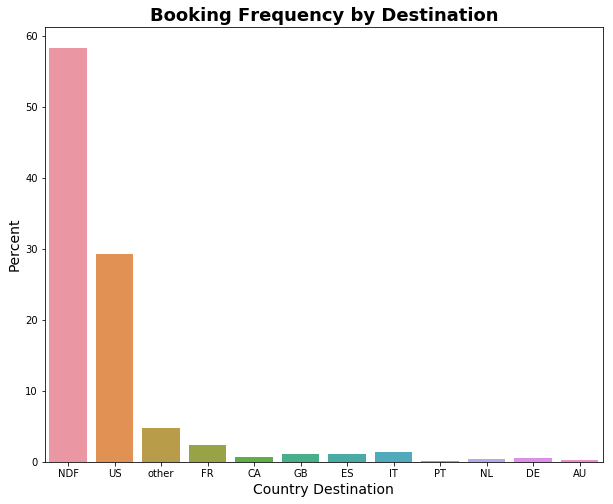

In [4]:
ax = sns.barplot(x="country_destination", y="signup_flow", data=users, estimator=lambda x: len(x) / len(users) * 100)
plt.title("Booking Frequency by Destination", fontsize=18, fontweight='bold')
plt.xlabel("Country Destination",fontsize=14)
plt.ylabel("Percent", fontsize=14)
#Here I pass 'signup_flow as my y variable simply because it is a numeric variable.  
#This allows me to normalize the barchart for country_destination counts and checks out with the percentage values 
#obtained from our value_counts command in a previous version.

NDF stands for No Destination Finalized.  It appears that nearly 60% of the domestic users in our data set ultimately exit the browsing session without making a booking.  Of the users who do book, the majority choose to visit other locations within the United States.  To predict what bookings users will make, we will emoploy a tiered approach by first creating a model designed to predict whether a user chooses to book a destination.  We will then make use of this prediction to inform a second model predicting where users choose to book.

**Make Train/Test Split for Binary Classification Model**

In [5]:
#Create variable for whether a user booked at all
users['Booked?'] = np.where(users['date_first_booking'].isnull(), 0, 1) 
target = users['Booked?']
target2 = users['country_destination']
xtrain, xtest, ytrain, ytest = train_test_split(users.copy(), target, test_size=0.2, random_state=42)

By splitting training data into two pieces we will be able to train our model to run properly on the first piece and then test it on the second to gauge how our model performs out of sample.  We can now inspect the training split more closely to prepare it for analysis.

## Data Cleaning and Feature Engineering

Let's take a look our data types:

In [6]:
xtrain.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
Booked?                      int64
dtype: object

We have a lot of object types in our data that will need to be transformed if we choose to use them.  Let's set aside the variables we want to drop and the ones we want to convert into dummy variables.

In [7]:
# Create drop and dummy arrays
drop = []
dummies = []

In [8]:
# Displays the columns with null values and the percent of null values for each column
print("Columns\t\t\t % Null")
xtrain[xtrain.columns[xtrain.isnull().any()]].isnull().sum()/len(xtrain)

Columns			 % Null


date_first_booking         0.583860
age                        0.412573
first_affiliate_tracked    0.028789
dtype: float64

Date of booking null values indicate that no booking was ever made, so a high proportion of nulls in this category is no surprise. Age is the only glaring null-value issue with the data, as over 40% of values are missing. We may be able to find a way to fill these values with the average age conditional on the users other observable characteristics; e.g. female mac owners who use chrome.

In [9]:
drop.extend(['Booked?','country_destination','id','date_first_booking'])

Let's inspect each of these features, one by one.

**Date Account Created**

In [10]:
xtrain.date_account_created.head()# Need to extract usable variables

139642    2014-01-09
519       2010-05-04
120664    2013-10-30
84733     2013-06-18
183255    2014-05-01
Name: date_account_created, dtype: object

We need to convert this variable into a date time so that we can extract the relevant information we need for analysis.  We will then create quantitative variables corresponding to year, month, and day of the week.

In [11]:
xtrain.date_account_created = pd.to_datetime(xtrain.date_account_created) #Casts object as datetime
xtest.date_account_created = pd.to_datetime(xtest.date_account_created)
test.date_account_created = pd.to_datetime(test.date_account_created)
users.date_account_created = pd.to_datetime(users.date_account_created)

In [12]:
# Create indicators for day of week (0=Mon, 6=Sun) account was created
xtrain['day_of_week_created'] = xtrain.date_account_created.dt.weekday
xtest['day_of_week_created'] = xtest.date_account_created.dt.weekday
test['day_of_week_created'] = test.date_account_created.dt.weekday
users['day_of_week_created'] = users.date_account_created.dt.weekday
# Create indicators for day of month (0 through 31), month (0 through 12), and year account created
xtrain['day_of_month_created'] = xtrain['date_account_created'].dt.day
xtest['day_of_month_created'] = xtest['date_account_created'].dt.day
test['day_of_month_created'] = test['date_account_created'].dt.day
users['day_of_month_created'] = users['date_account_created'].dt.day
xtrain['month_created'] = xtrain['date_account_created'].dt.month
xtest['month_created'] = xtest['date_account_created'].dt.month
test['month_created'] = test['date_account_created'].dt.month
users['month_created'] = users['date_account_created'].dt.month
xtrain['year_created'] = xtrain['date_account_created'].dt.year
xtest['year_created'] = xtest['date_account_created'].dt.year
test['year_created'] = test['date_account_created'].dt.year
users['year_created'] = users['date_account_created'].dt.year
# Note that a function would not decrease the number of lines of code

In addition to deconstructing the date_account_created variable, we created a variable that measures how old the account is relative to the others. This is done by subtracting date_account_created by a new variable called "today." Afterwards, these variables are added either to the dummy or the drop list.

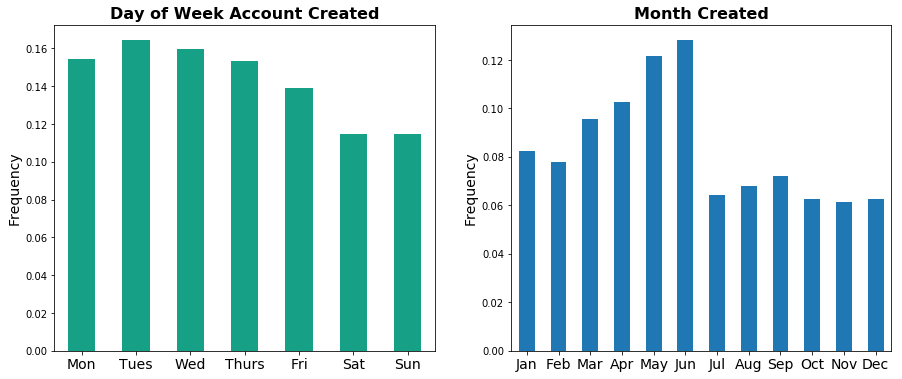

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
xtrain.day_of_week_created.value_counts(normalize=1).sort_index().plot(kind='bar',x=[0,1,2,3,4,5,6],color='#16A085')
plt.title('Day of Week Account Created', fontsize=16,fontweight='bold')
plt.xticks(np.arange(0,7,1),['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'], rotation=0, fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.subplot(1,2,2)
xtrain.month_created.value_counts(normalize=1).sort_index().plot(kind='bar',x=np.arange(0,12,1))
plt.title('Month Created',fontsize=16,fontweight='bold')
plt.xticks(np.arange(0,12,1), calendar.month_abbr[1:],rotation=0,fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.show()

In [14]:
drop.append('date_account_created')
dummies.extend(['day_of_week_created'])

In [15]:
#create a today variable, which we will turn into a datetime and subtract from our date_account_created var
xtrain['today'] = datetime.date.today()
xtest['today'] = datetime.date.today()
test['today'] = datetime.date.today()
users['today'] = datetime.date.today()
xtrain.today = pd.to_datetime(xtrain.today)
xtest.today = pd.to_datetime(xtest.today)
test.today = pd.to_datetime(test.today)
users.today = pd.to_datetime(users.today)

#subtract today from date_account_created to get account_life
xtrain['account_life'] = xtrain['today'].sub(xtrain['date_account_created'], axis=0)
xtest['account_life'] = xtest['today'].sub(xtest['date_account_created'], axis=0)
test['account_life'] = test['today'].sub(test['date_account_created'], axis=0)
users['account_life'] = users['today'].sub(users['date_account_created'], axis=0)

#assign account_life var to 5 equal bins, will be created when it is appended to the dummy dataframe.
xtrain['account_life_bins'] = pd.qcut(xtrain['account_life'], 5, labels=False)
xtest['account_life_bins'] = pd.qcut(xtest['account_life'], 5, labels=False)
test['account_life_bins'] = pd.qcut(test['account_life'], 5, labels=False)
users['account_life_bins'] = pd.qcut(users['account_life'], 5, labels=False)

#appending to dummies df
dummies.append('account_life_bins')
#drop unnecessary columns
drop.extend(['today','account_life','date_account_created'])

**Gender**

Text(0,0.5,'Proportion')

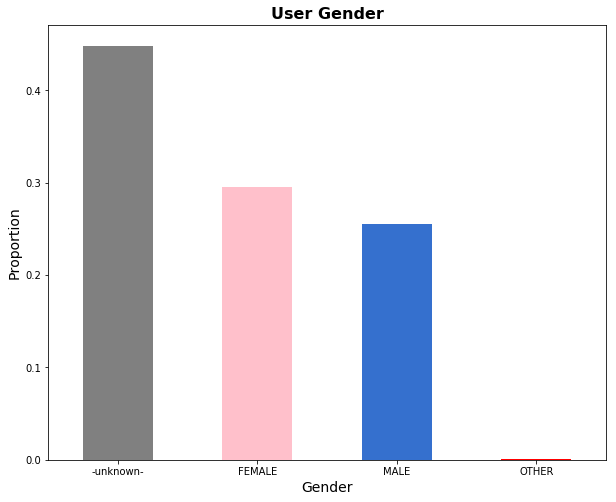

In [16]:
xtrain['gender'].value_counts(normalize=1).plot(kind='bar', color=[['grey','pink','#3570ce','red']])
plt.title('User Gender', fontsize=16,fontweight='bold')
plt.xlabel('Gender', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)

Unknown should be kept as a variable, and should not try to fill, given that it is very likely that the model will see unknown genders in the test set. 

In [17]:
dummies.append('gender')

**Age**

In [18]:
xtrain.age.describe()

count    100309.000000
mean         49.658186
std         155.692226
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [19]:
print("% Individuals older than 95: {}".format(sum((xtrain.age > 95)/len(xtrain.age)).round(4)))
print("% Individuals younger than 18: {}".format((sum(xtrain.age < 18)/len(xtrain.age)).round(4)))

% Individuals older than 95: 0.0114
% Individuals younger than 18: 0.0007


According to the age distribution statistics, it appears that the data contains individuals with implausible ages exceeding 120 years. We may be better suited to only include individuals under the age of 100 in our analysis and modeling.

In [20]:
# Statistics on individuals with age less than 95
xtrain[xtrain.age<95]['age'].describe()

count    98327.000000
mean        36.464582
std         11.509192
min          1.000000
25%         28.000000
50%         33.000000
75%         42.000000
max         94.000000
Name: age, dtype: float64

Text(0.5,1,'Age Distribution')

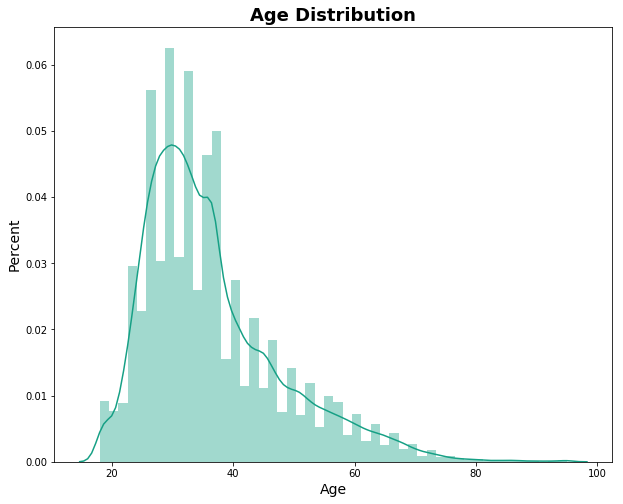

In [21]:
train_mean_age = xtrain[(xtrain.age<95) & (xtrain.age>18)].age.mean()
sns.distplot(xtrain['age'].apply(lambda x : train_mean_age if x>95 or x < 18 else x).dropna(), color='#16A085')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.title('Age Distribution', fontsize=18, fontweight='bold')

Most of our dataset is comprised of 25-40-year-olds, and there is a small number of users that are younger than Airbnb terms of service allow to book rooms.  We will also have to do address the bizarre ages in the thousands.

In [22]:
#Change all unusable ages to NaN:
xtrain.loc[xtrain.age > 95, 'age'] = np.nan
xtrain.loc[xtrain.age < 18, 'age'] = np.nan
xtest.loc[xtest.age > 95, 'age'] = np.nan
xtest.loc[xtest.age < 18, 'age'] = np.nan
test.loc[test.age > 95, 'age'] = np.nan
test.loc[test.age < 18, 'age'] = np.nan
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 18, 'age'] = np.nan
# Airbnb users must be 18 by law

In [23]:
# Here is a neat way to impute missing age values
train_std_age = xtrain[(xtrain.age<95) & (xtrain.age>18)].age.std()
# Generate random ages within one standard deviation of the mean for train, xtest, and test sets respectively
rand1 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtrain.age.isnull().sum())
rand2 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtest.age.isnull().sum())
rand3 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=test.age.isnull().sum())
rand4 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=users.age.isnull().sum())

In [24]:
# Create a series to preserve the indices of NaNs
xtrain['age'] = xtrain['age'].fillna(pd.Series(rand1, xtrain[xtrain.age.isnull()].index))
xtest['age'] = xtest['age'].fillna(pd.Series(rand2, xtest[xtest.age.isnull()].index))
test['age'] = test['age'].fillna(pd.Series(rand3, test[test.age.isnull()].index))
users['age'] = users['age'].fillna(pd.Series(rand4, users[users.age.isnull()].index))

Text(0.5,1,'Age Distribution by Destination')

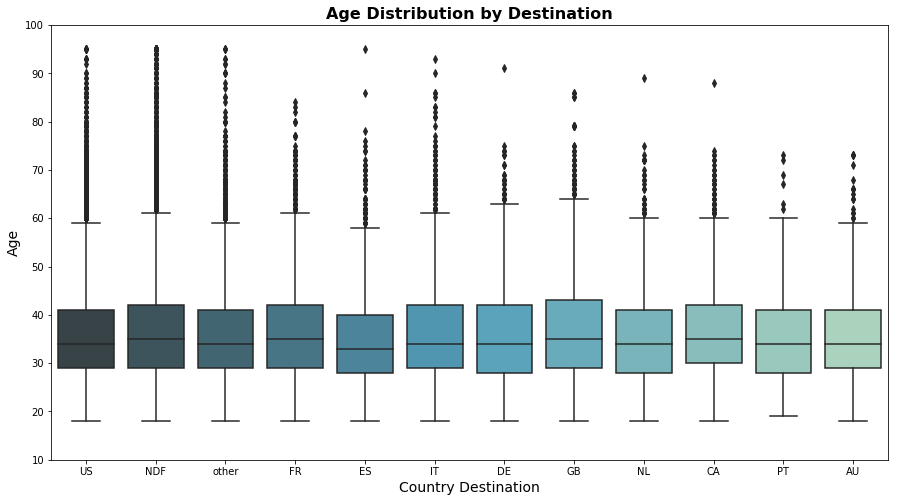

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=xtrain, palette="GnBu_d", ax =ax)
ax.set_ylim([10, 100])
plt.xlabel('Country Destination',fontsize=14)
plt.ylabel('Age',fontsize=14)
plt.title('Age Distribution by Destination',fontsize=16,fontweight='bold')

**Signup Method**

Text(0,0.5,'Proportion')

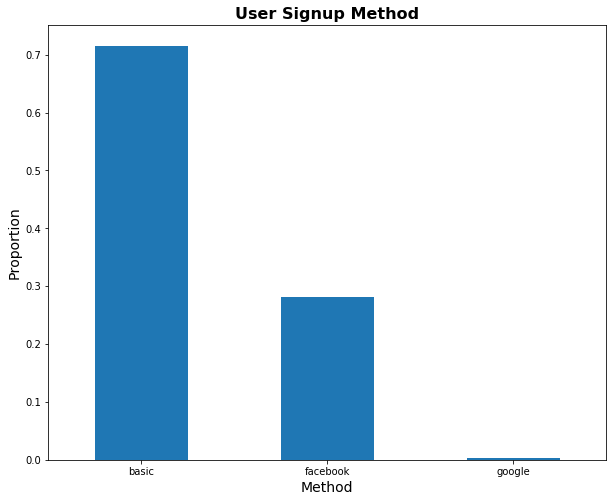

In [26]:
xtrain['signup_method'].value_counts(normalize=True, dropna=False).plot(kind='bar')
plt.title('User Signup Method', fontsize=16,fontweight='bold')
plt.xlabel('Method', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)

In [27]:
keep = ['basic','facebook','google']
# Prevents columns contained in test set but not in training set from causing issues
test.loc[~test.signup_method.isin(keep),'signup_method'] = np.nan

In [28]:
dummies.append('signup_method')

Signup Method is a rather straightforward dummy case, and there are no null values to fill in for, as per the null value analysis done previously in the notebook. However, there are some values in signup_flow that appear in the test data but not in the training data. To correct this anomaly, we restrict the test signup_flow values to those that are contained in the training data.

**Signup Flow**

This feature indicates from which Airbnb internet channel a user signed up.

In [29]:
xtrain['signup_flow'].value_counts(normalize=True, dropna=False)

0     0.771598
25    0.068880
12    0.043816
3     0.041210
2     0.032109
24    0.020502
23    0.013147
1     0.004878
6     0.001482
8     0.001113
21    0.000925
5     0.000170
20    0.000070
16    0.000047
15    0.000041
4     0.000006
10    0.000006
Name: signup_flow, dtype: float64

In [30]:
# Replace values consisting of less than 0.1% of the data with the 'signup_flow' mode, 0
replace_vals = np.arange(1,25,1)
xtrain.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
xtest.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
test.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
users.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)

In [31]:
dummies.append('signup_flow')

**Language**

Text(0.5,0,'Proportion')

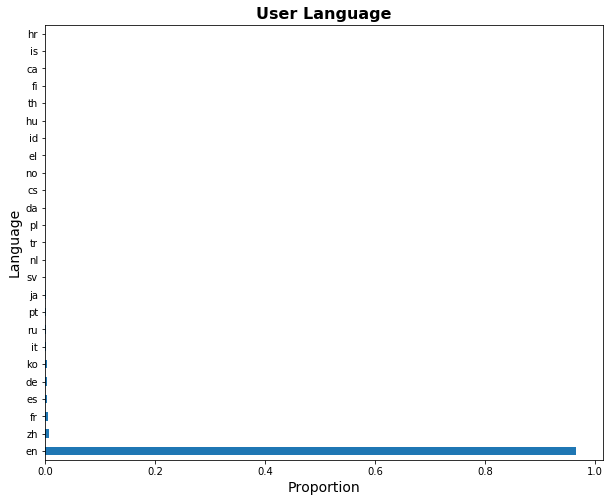

In [32]:
xtrain['language'].value_counts(normalize=1, dropna=1).plot(kind='barh')
plt.title('User Language', fontsize=16,fontweight='bold')
plt.ylabel('Language', fontsize=14)
plt.xlabel('Proportion', fontsize=14)

Since 96% of all users speak English, the language variable may provide little insight. Making dummies for all of the languages seems illogical. We could consider creating dummies for English (eh), Chinese (zh), and an 'other' category.

In [33]:
xtrain.language = xtrain.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
xtest.language = xtest.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
test.language = test.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
users.language = users.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')

In [34]:
dummies.append('language')

**Affiliate Channel**

Text(0,0.5,'Proportion')

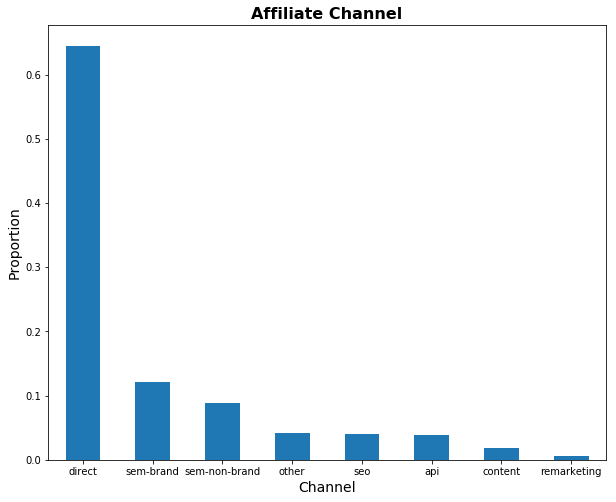

In [35]:
xtrain.affiliate_channel.value_counts(normalize=True, dropna=False).plot(kind='bar')# note 'api' isn't in test data
plt.title('Affiliate Channel', fontsize=16,fontweight='bold')
plt.xlabel('Channel', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)

Since there are values of affiliate_channel contained int the training data but not in the test data, we must restrict the values to those contained in the intersection of test and training data.

In [36]:
keep2 = test.affiliate_channel.unique()
xtrain.loc[~xtrain.affiliate_channel.isin(keep2),'affiliate_channel'] = np.nan
xtest.loc[~xtest.affiliate_channel.isin(keep2),'affiliate_channel'] = np.nan
users.loc[~users.affiliate_channel.isin(keep2),'affiliate_channel'] = np.nan

In [37]:
dummies.append('affiliate_channel')

**Affiliate Provider**

In [38]:
xtrain.affiliate_provider.value_counts(normalize=True, dropna=False)

direct                 0.643640
google                 0.241614
other                  0.059241
craigslist             0.016544
bing                   0.011097
facebook               0.010606
vast                   0.003842
padmapper              0.003613
facebook-open-graph    0.002588
yahoo                  0.002290
gsp                    0.002073
meetup                 0.001628
email-marketing        0.000755
naver                  0.000234
baidu                  0.000129
yandex                 0.000070
wayn                   0.000029
daum                   0.000006
Name: affiliate_provider, dtype: float64

In [39]:
#Make dummies for the categories consisting of more than 3%
xtrain.affiliate_provider = xtrain.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
xtest.affiliate_provider = xtest.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
test.affiliate_provider = test.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
users.affiliate_provider = users.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
dummies.append('affiliate_provider')

**First Affiliate Tracked**

First marketing interacted with by the user before signing up.

In [40]:
xtrain.first_affiliate_tracked.value_counts(normalize=True, dropna=False)

untracked        0.510606
linked           0.217270
omg              0.206055
tracked-other    0.029035
NaN              0.028789
product          0.007408
marketing        0.000673
local ops        0.000164
Name: first_affiliate_tracked, dtype: float64

In [41]:
# Fills null values with variable mode, which is 'untracked'
xtrain.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
xtest.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
test.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
users.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
dummies.append('first_affiliate_tracked')

**Signup App**

In [42]:
xtrain.signup_app.value_counts(normalize=True, dropna=False)

Web        0.855651
iOS        0.089506
Moweb      0.029351
Android    0.025492
Name: signup_app, dtype: float64

In [43]:
dummies.append('signup_app')

**First Device Type**

In [44]:
xtrain.first_device_type.value_counts(normalize=True, dropna=False)

Mac Desktop           0.419320
Windows Desktop       0.340976
iPhone                0.097242
iPad                  0.067071
Other/Unknown         0.050158
Android Phone         0.013317
Android Tablet        0.006108
Desktop (Other)       0.005452
SmartPhone (Other)    0.000357
Name: first_device_type, dtype: float64

In [45]:
dummies.append('first_device_type')

**First Browser**

In [46]:
xtrain.first_browser.value_counts(normalize=True, dropna=False)

Chrome                  0.298969
Safari                  0.210957
Firefox                 0.157900
-unknown-               0.127987
IE                      0.098969
Mobile Safari           0.090015
Chrome Mobile           0.006196
Android Browser         0.004035
AOL Explorer            0.001113
Opera                   0.000896
Silk                    0.000597
Chromium                0.000328
BlackBerry Browser      0.000246
Maxthon                 0.000240
Apple Mail              0.000176
IE Mobile               0.000152
Mobile Firefox          0.000152
Sogou Explorer          0.000146
SiteKiosk               0.000141
RockMelt                0.000123
Iron                    0.000082
Pale Moon               0.000064
IceWeasel               0.000059
Yandex.Browser          0.000053
CometBird               0.000047
Camino                  0.000047
TenFourFox              0.000041
CoolNovo                0.000035
SeaMonkey               0.000035
wOSBrowser              0.000035
Opera Mini

In [47]:
vlist = ['Chrome', 'Safari', '-unknown-', 'Firefox', 'Mobile Safari', 'IE']
xtrain.first_browser = xtrain.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
xtest.first_browser = xtest.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
test.first_browser = test.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
users.first_browser = users.first_browser.apply(lambda x: x if str(x) in vlist else 'other')

In [48]:
dummies.append('first_browser')

In [49]:
test_ids = test['id'].to_frame()

In [50]:
drop

['Booked?',
 'country_destination',
 'id',
 'date_first_booking',
 'date_account_created',
 'today',
 'account_life',
 'date_account_created']

In [51]:
xtrain.drop(drop, axis=1, inplace=True)
xtest.drop(drop, axis=1, inplace=True)
test.drop(drop[2:], axis=1, inplace=True)
users.drop(drop[2:], axis=1, inplace=True)

In [52]:
xtrain = pd.get_dummies(xtrain, columns=dummies, dummy_na=False)
xtest = pd.get_dummies(xtest, columns=dummies, dummy_na=False)
test = pd.get_dummies(test, columns=dummies, dummy_na=False)
users = pd.get_dummies(users, columns=dummies, dummy_na=False)

## Modeling

### Binary Classification: To Book or Not to Book?

We first create a binary classification model to predict whether or not an individual will book an Airbnb. Our second model will then classify to which country a user will first visit given that they book a trip.

#### K-Neighbors Classifier

In [53]:
kn_clf = KNeighborsClassifier()

In [54]:
gridsearch_kn = GridSearchCV(kn_clf, {"n_neighbors": [3,5,7,9], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
%time gridsearch_kn.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_kn.best_params_))
knclf_ypredict_train = gridsearch_kn.predict(xtrain)
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain, knclf_ypredict_train)))
knclf_ypredict_test = gridsearch_kn.predict(xtest)
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest, knclf_ypredict_test)))

CPU times: user 7min 17s, sys: 9.41 s, total: 7min 26s
Wall time: 7min 32s
Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Training Accuracy Score: 0.6585382993675334
Test Accuracy Score: 0.5424562554168326


#### Random Forest

Because of the nature of our data, Random Forest may be a particularly suitable model for this problem.  The destination classes in our data are highly imbalanced toward no destination and United States which makes it difficult to predict the occurrence of minority classes.  Due to the hierarchical structure of tree-based algorithms, Random Forest should be less sensitive to this issue.

In [55]:
rf_clf = RandomForestClassifier()
gridsearch_rf = GridSearchCV(rf_clf, {"n_estimators": [30,60, 100, 200], "class_weight": ['balanced', None],
                                      "max_depth": [5,7,9,11]})

In [56]:
%time gridsearch_rf.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_rf.best_params_))
rfclf_ypredict_train = gridsearch_rf.predict(xtrain)

CPU times: user 11min 22s, sys: 19 s, total: 11min 41s
Wall time: 11min 46s
Best Parameters: {'class_weight': None, 'max_depth': 11, 'n_estimators': 100}


In [56]:
print("Test Classification Report:")
rfclf_ypredict_test = gridsearch_rf.predict(xtest)
print(metrics.classification_report(ytest, rfclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain, rfclf_ypredict_train),
                                                    metrics.accuracy_score(ytest, rfclf_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.81      0.74     24843
          1       0.64      0.47      0.54     17848

avg / total       0.66      0.67      0.66     42691

Train Accuracy: 0.6794214101663153
Test Accuracy: 0.6663699608816847


#### XGBoost

In [57]:
xgb_clf = xgb.XGBClassifier()

In [59]:
gridsearch_xgb = GridSearchCV(xgb_clf, {'n_estimators':[50,100,150],'max_depth':[3,5,7],'learning_rate':[.01,.05]})

In [60]:
%time gridsearch_xgb.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_xgb.best_params_))

CPU times: user 37min 45s, sys: 10.7 s, total: 37min 56s
Wall time: 38min 2s
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


In [61]:
xgbclf_ypredict_train = gridsearch_xgb.predict(xtrain)

In [62]:
print("Test Classification Report:")
xgbclf_ypredict_test = gridsearch_xgb.predict(xtest)
print(metrics.classification_report(ytest, xgbclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain, xgbclf_ypredict_train),
                                                    metrics.accuracy_score(ytest, xgbclf_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.69      0.79      0.74     24843
          1       0.63      0.51      0.56     17848

avg / total       0.67      0.67      0.66     42691

Train Accuracy: 0.6782150386507378
Test Accuracy: 0.6708439717973343


### Multiple Classification: Country Destination

In [82]:
# Selects xtrain indices from multiclass target2 and creates new ytrain series
ytrain2 = target2[xtrain.index][target2!='NDF']

In [83]:
xtrain2 = xtrain.loc[ytrain2.index]

In [84]:
ytest2 = target2[xtest.index][target2!='NDF']

In [85]:
xtest2 = xtest.loc[ytest2.index]

#### K-Neighbors Classifier

In [67]:
gridsearch_kn2 = GridSearchCV(kn_clf, {"n_neighbors": [5,7,9], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
%time gridsearch_kn2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_kn2.best_params_))
knclf2_ypredict_train = gridsearch_kn2.predict(xtrain2)
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain2, knclf2_ypredict_train)))
knclf2_ypredict_test = gridsearch_kn2.predict(xtest2)
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest2, knclf2_ypredict_test)))

CPU times: user 1min 57s, sys: 2.8 s, total: 2min
Wall time: 2min 1s
Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Training Accuracy Score: 0.7027300872502111
Test Accuracy Score: 0.6949238009861048


#### Random Forest

In [68]:
gridsearch_rf2  = GridSearchCV(rf_clf, {"n_estimators": [20,60,100,200], "class_weight": ['balanced', None],
                                      "max_depth": [3,5,7,9]})

In [69]:
%time gridsearch_rf2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_rf2.best_params_))
rfclf2_ypredict_train = gridsearch_rf2.predict(xtrain2)

CPU times: user 3min 47s, sys: 7.37 s, total: 3min 54s
Wall time: 3min 55s
Best Parameters: {'class_weight': None, 'max_depth': 3, 'n_estimators': 20}


In [81]:
rfclf2_ypredict_test = gridsearch_rf2.predict(xtest2)
print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain2, rfclf2_ypredict_train),
                                                    metrics.accuracy_score(ytest2, rfclf2_ypredict_test)))

#### XGBoost

In [72]:
gridsearch_xgb2 = GridSearchCV(xgb_clf, {'n_estimators':[10,30,60],'max_depth':[3,5,7],'learning_rate':[.01,.05,.1]})
%time gridsearch_xgb2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_xgb2.best_params_))

In [ ]:
xgbclf2_ypredict_train = gridsearch_xgb2.predict(xtrain2)
print("Test Classification Report:")
xgbclf2_ypredict_test = gridsearch_xgb2.predict(xtest2)
print(metrics.classification_report(ytest2, xgbclf2_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain2, xgbclf2_ypredict_train),
                                                    metrics.accuracy_score(ytest2, xgbclf2_ypredict_test)))

## Predictions

In [81]:
# Binary classification model to predict which users will book
book_predictions = gridsearch_rf.best_estimator_.predict(test)

In [73]:
predictions_df = pd.DataFrame(data=book_predictions, columns=['Booked'])
predictions_df['Booked'].value_counts(normalize=True)

0    0.773061
1    0.226939
Name: Booked, dtype: float64

In [74]:
country_predictions = gridsearch_rf2.best_estimator_.predict(test)

In [75]:
test_ids['country'] = country_predictions

In [76]:
# Fills the users destination whom were predicted not to book with 'NDF' 
test_ids.loc[predictions_df[predictions_df['Booked']==0].index,'country'] = 'NDF'

In [77]:
test_ids.country.value_counts(normalize=True)

NDF    0.773061
US     0.226939
Name: country, dtype: float64

In [78]:
test_ids.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


In [79]:
test_ids.to_csv('submission1.csv', index=False)

## Results

When we submit these results to Kaggle we obtain an accuracy of 69.43%.  This is higher than Kaggle's baseline result but doesn't yet measure up to our expectations for the model.  We will now consider a few further directions that may help us to improve our model's accuracy going forward.

### Direction #1-- Correcting Class Imbalance

One challenge we face from the Airbnb data provided in this problem is the vast asymmetry between the different classes-- 95% of our observations fall into either the US destination or no booking category.  There are a few ways we can potentially go about correcting this problem.

1) We can up-sample the minority population

2) We can down-sample the majority population

3) Change evaluation metric

4) Employ Penalization Algorithms

### Direction #2-- Ensemble

Rather than employ a two-tier approach, we could create a unified ensemble model that treats NDF as its own destination class and utilizes various models to predict outcome.  This approach tends to boost the accuracy at the price of longer runtime.  Let's give this approach a try.

In [89]:
# Selects xtrain indices from multiclass target2 and creates new ytrain series
ytrain3 = target2[xtrain.index]

In [90]:
xtrain3 = xtrain.loc[ytrain3.index]

In [91]:
ytest3 = target2[xtest.index]

In [92]:
xtest3 = xtest.loc[ytest3.index]

In [226]:
#target_ = users.country_destination
#users.drop(['country_destination','Booked?'],axis=1,inplace=True)
#xtrain_, xtest_, ytrain_, ytest_ = train_test_split(users.copy(), target_, test_size=.2, random_state=42)

In [98]:
gridsearch_rf3  = GridSearchCV(rf_clf, {"n_estimators": [20,150,200], "class_weight": ['balanced', None],
                                      "max_depth": [3,5,7,9]}, scoring='f1_weighted')

In [99]:
%time gridsearch_rf3.fit(xtrain3,ytrain3)
print("Best Parameters: {}".format(gridsearch_rf3.best_params_))
rfclf3_ypredict_train = gridsearch_rf3.predict(xtrain3)

CPU times: user 10min 14s, sys: 29.8 s, total: 10min 44s
Wall time: 10min 46s
Best Parameters: {'class_weight': None, 'max_depth': 9, 'n_estimators': 150}


In [101]:
rfclf3_ypredict_test = gridsearch_rf3.predict(xtest3)
print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain3, rfclf3_ypredict_train),
                                                    metrics.accuracy_score(ytest3, rfclf3_ypredict_test)))

Train Accuracy: 0.6137620051534317
Test Accuracy: 0.6060527980136329


In [103]:
print(metrics.classification_report(ytest3, rfclf3_ypredict_test))

             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       114
         CA       0.00      0.00      0.00       275
         DE       0.00      0.00      0.00       208
         ES       0.00      0.00      0.00       451
         FR       0.00      0.00      0.00      1010
         GB       0.00      0.00      0.00       497
         IT       0.00      0.00      0.00       562
        NDF       0.63      0.93      0.75     24843
         NL       0.00      0.00      0.00       155
         PT       0.00      0.00      0.00        45
         US       0.48      0.23      0.31     12525
      other       0.00      0.00      0.00      2006

avg / total       0.51      0.61      0.53     42691



In [116]:
feats = {} # Dictionary of feature_name: feature_importance
for feature, importance in zip(xtrain3.columns, gridsearch_rf3.best_estimator_.feature_importances_):
    feats[feature] = importance #add the name/value pair to dictionary

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

Text(0,0.5,'Gini Importance')

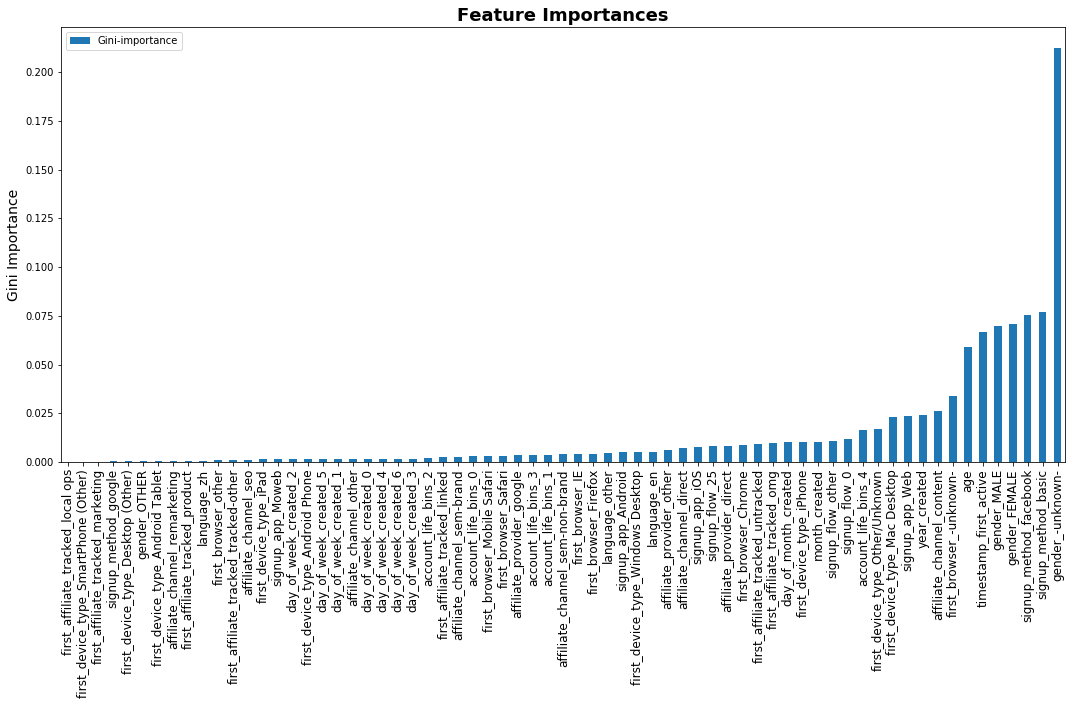

In [125]:
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90,figsize=(18,8))
plt.title('Feature Importances', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12)
plt.ylabel('Gini Importance', fontsize=14)

In [151]:
# Returns values whose gini importance is greater than 0.01
top_features = importances[importances['Gini-importance']>0.01].index

In [169]:
xtop_train = xtrain[top_features]
xtop_test = xtest[top_features]

In [173]:
gridsearch_rf4 = GridSearchCV(rf_clf, {"n_estimators": [75,150,500], "class_weight": ['balanced', None],
                                      "max_depth": [3,5,7]}, scoring='f1_weighted')

In [174]:
%time gridsearch_rf4.fit(xtop_train,ytrain3)
print("Best Parameters: {}".format(gridsearch_rf4.best_params_))
rfclf4_ypredict_train = gridsearch_rf4.predict(xtop_train)

CPU times: user 11min 25s, sys: 39.7 s, total: 12min 5s
Wall time: 12min 14s
Best Parameters: {'class_weight': None, 'max_depth': 7, 'n_estimators': 500}


In [175]:
rfclf4_ypredict_test = gridsearch_rf4.predict(xtop_test)
print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain3, rfclf3_ypredict_train),
                                                    metrics.accuracy_score(ytest3, rfclf3_ypredict_test)))

Train Accuracy: 0.6137620051534317
Test Accuracy: 0.6060527980136329


### Direction #3-- Use Kaggle as the Validation Set

Rather than give up a portion of our data to train our model we can try pooling the entire users set for training and test its out of sample accuracy against the testing set provided by Airbnb.  This allows us to maximize the amount of usable data which can often compensate for a lot of problems.

## Conclusion

As we explore these additional avenues we anticipate being able to exceed our initial baseline to construct a dependable algorithm that services such as Airbnb can use to better serve their customers and provide targeted marketing directly to those most likely to benefit.  By finding those most responsive to this business model we can approach an answer to the age-old advertising problem of discovering which users will be receptive to our efforts.  

## Questions and Feedback